In [13]:
from collections import defaultdict
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import quadpy
from aabbtree import AABB, AABBTree

from polygon_clipping import PolygonClipper

from numba import jit

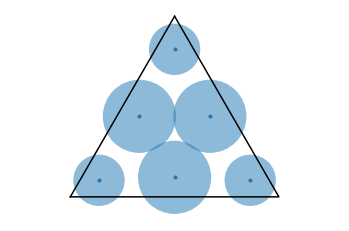

In [14]:
scheme = quadpy.t2.get_good_scheme(4)
scheme.show()
quadrature = list(zip(scheme.weights, scheme.points[:2].T))

In [15]:
P1_2D_bases = [
    lambda uv: 1 - uv[0] - uv[1],
    lambda uv: uv[0],
    lambda uv: uv[1]
]

def P1_2D_gmapping(uv, nodes):
        return sum(phi(uv) * x for phi, x in zip(P1_2D_bases, nodes))

# Compute barycentric coordinates (u, v, w) for point p with respect to triangle (a, b, c)
@jit(nopython=True)
def barycentric_coordinates(p, a, b, c):
    v0 = b - a
    v1 = c - a
    v2 = p - a
    d00 = np.dot(v0, v0)
    d01 = np.dot(v0, v1)
    d11 = np.dot(v1, v1)
    d20 = np.dot(v2, v0)
    d21 = np.dot(v2, v1)
    denom = d00 * d11 - d01 * d01
    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1 - v - w
    return [u, v, w]

class Element:
    def __init__(self, loc_2_glob, nodes):
        self.nodes = nodes
        self.loc_2_glob = loc_2_glob

    def gmapping(self, uv):
        return P1_2D_gmapping(uv, self.nodes)

    def grad_gmapping(self, uv):
        return 0.5 * np.linalg.norm(np.cross(
            self.nodes[1] - self.nodes[0], self.nodes[2] - self.nodes[0]))

    def inv_gmapping(self, point):
        return barycentric_coordinates(point, *self.nodes)[1:]

    def bases(self):
        return zip(self.loc_2_glob, P1_2D_bases)

class FEMesh:
    def __init__(self, V, F):
        self.elements = []
        for f in F:
            self.elements.append(Element(f, V[f]))
        self.nodes = V.copy()

In [16]:
def build_mass_matrix(mesh):
    M = scipy.sparse.lil_matrix((len(mesh.nodes), len(mesh.nodes)))
    for element in mesh.elements:
        for i, phi_i in element.bases():
            for j, phi_j in element.bases():
                for w, x in quadrature:
                    M[i, j] += w * phi_i(x) * phi_j(x) * element.grad_gmapping(x)
    return M.tocsc()

In [17]:
def nodes_to_aabb(nodes):
    return AABB(np.vstack([nodes.min(axis=0), nodes.max(axis=0)]).T)

def triangle_fan(convex_polygon):
    assert(len(convex_polygon) >= 3)
    triangles = []
    for i in range(1, len(convex_polygon) - 1):
        triangles.append([convex_polygon[0], convex_polygon[i], convex_polygon[i+1]])
    return triangles

def triangle_area(vertices):
    return 0.5 * np.linalg.det(np.hstack([vertices, np.ones((3, 1))]))

def build_mass_matrix_cross(mesh_a, mesh_b):
    A = scipy.sparse.lil_matrix((len(mesh_b.nodes), len(mesh_a.nodes)))
    
    tree = AABBTree()
    for i, element_a in enumerate(mesh_a.elements):
        tree.add(nodes_to_aabb(element_a.nodes), i)

    clip = PolygonClipper(warn_if_empty = False)

    for element_b in mesh_b.elements:
        assert(triangle_area(element_b.nodes) > 0)
        for element_a_ids in tree.overlap_values(nodes_to_aabb(element_b.nodes)):
            element_a = mesh_a.elements[element_a_ids]
            assert(triangle_area(element_a.nodes) > 0)
            
            overlap = clip(element_b.nodes[::-1], element_a.nodes[::-1])[::-1]
            if(len(overlap) < 3):
                continue
            triangles = triangle_fan(overlap)

            for tri in triangles:
                area = triangle_area(tri)
                if abs(area) < 1e-8:
                    continue
                assert(area > 0)
                for w, sub_x_i in quadrature:
                    p = P1_2D_gmapping(sub_x_i, tri)
                    x_i = element_b.inv_gmapping(p)
                    x_j = element_a.inv_gmapping(p)
                    for i, phi_i in element_b.bases():
                        for j, phi_j in element_a.bases():
                            A[i, j] += w * phi_i(x_i) * phi_j(x_j) * area #element_b.grad_gmapping(x_i) * area

    return A.tocsc()

In [18]:
def L2_projection(mesh_a, mesh_b, u):
    """
    Project the quantities in u on to the space spanned by mesh.bases.
    
    Note: in this context u and u_h are the coefficients.
    """
    M = build_mass_matrix(mesh_b)
    A = build_mass_matrix_cross(mesh_a, mesh_b)
    u_h = scipy.sparse.linalg.spsolve(M, A @ u) # b = A @ u
    # vel_h = solve(M, A @ vel)
    return u_h

In [19]:
import triangle

def generate_random_square_triangulation(n=50, allow_steiner=True):
    points = np.vstack([
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 1],
        0.9 * np.random.random((n - 4, 2)) + 0.05,
    ]) - [0.5, 0.5]
    boundary = [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 0],
    ]
    max_area = 100
    tri = triangle.triangulate({"vertices": points, "segments": boundary}, f'{"" if allow_steiner else "Y"}a{max_area:f}q')
    return tri["vertices"], tri["triangles"]

In [20]:
import  meshplot as mp

def plot_mesh(V, F, u=None, **kwargs):
    shading = {
        "flat": True, # Flat or smooth shading of triangles
        "wireframe": True, "wire_width": 0.1, "wire_color": "black", # Wireframe rendering
        "width": 600, "height": 600, # Size of the viewer canvas
        "antialias": True, # Antialising, might not work on all GPUs
        "scale": 2.0, # Scaling of the model
        "side": "DoubleSide", # FrontSide, BackSide or DoubleSide rendering of the triangles
        "colormap": "viridis", "normalize": [None, None], # Colormap and normalization for colors
        "background": "#ffffff", # Background color of the canvas
        "line_width": 2.0, "line_color": "black", # Line properties of overlay lines
        "bbox": False, # Enable plotting of bounding box
        "point_color": "red", "point_size": 0.05 # Point properties of overlay points
    }
    shading.update(kwargs)
    return mp.plot(V, F, c=u, shading=shading)

In [33]:
np.random.seed(0)
plot_mesh(*generate_random_square_triangulation())
plot_mesh(*generate_random_square_triangulation())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [22]:
def test():
    mesh_a = FEMesh(*generate_random_square_triangulation())
    mesh_b = FEMesh(*generate_random_square_triangulation())
    u = np.ones(len(mesh_a.nodes))
    print(np.linalg.norm(
        L2_projection(mesh_b, mesh_a, L2_projection(mesh_a, mesh_b, u)) - u, 
    ord=np.inf))

In [23]:
test()

5.706546346573305e-14


In [24]:
def perform_n_L2_projections(n, u=lambda x, y: 1):
    errors = {"analytical": [], "initial_space": []}

    mesh0 = FEMesh(*generate_random_square_triangulation())
    u0 = np.array([u(*node) for node in mesh0.nodes])
    
    u_prev = u0
    mesh_prev = mesh0
    
    for i in range(n):
        mesh = FEMesh(*generate_random_square_triangulation())
        u_prev = L2_projection(mesh_prev, mesh, u_prev)
        errors["analytical"].append(np.linalg.norm(
            np.array([u(*node) for node in mesh.nodes]) - u_prev, ord=np.inf))
        errors["initial_space"].append(np.linalg.norm(
            L2_projection(mesh, mesh0, u_prev) - u0, ord=np.inf))
        mesh_prev = mesh
    
    return errors


In [25]:
np.random.seed(0)
uniform_errors = perform_n_L2_projections(10)

KeyboardInterrupt: 

In [ ]:
from plotly import graph_objects as go
plot_layout = dict(
    width=1200,
    xaxis=dict(ticks="inside"), 
    yaxis=dict(ticks="inside", title="error (L infinity)", exponentformat="power"),
    template="simple_white",
    font=dict(size=18),
    legend=dict(orientation="h", yanchor="top", y=1.15, xanchor="right", x=0.99, bgcolor='rgba(0,0,0,0)', font_size=18),
    margin=dict(l=10, r=10, t=60, b=10)
)

fig = go.Figure(data=[
    go.Scatter(x=np.arange(1, 11), y=uniform_errors["analytical"], line=dict(width=5), marker=dict(size=10), name="analytical"),
    go.Scatter(x=np.arange(1, 11), y=uniform_errors["initial_space"], line=dict(width=5), marker=dict(size=10), name="initial space"),
])
fig.update_layout(
    title=dict(text="L2 Projection Error (u(x,y) = 1)", x=0.5),
    **plot_layout
)
fig.show()
fig.write_image("u=1.png")

In [ ]:
np.random.seed(0)
cos_errors = perform_n_L2_projections(10, u=lambda x, y: np.cos(x) + np.cos(y))

In [ ]:
fig = go.Figure(data=[
    go.Scatter(x=np.arange(1, 11), y=cos_errors["analytical"], line=dict(width=5), marker=dict(size=10), name="analytical"),
    go.Scatter(x=np.arange(1, 11), y=cos_errors["initial_space"], line=dict(width=5), marker=dict(size=10), name="initial space"),
])
fig.update_layout(
    title=dict(text="L2 Projection Error (u(x,y) = cos(x) + cos(y))", x=0.5),
    **plot_layout
)
fig.show()
fig.write_image("u=cos(x)+cos(y).png")

In [ ]:
np.random.seed(0)
cos10_errors = perform_n_L2_projections(10, u=lambda x, y: np.cos(10 * x) + np.cos(10 * y))

In [ ]:
fig = go.Figure(data=[
    go.Scatter(x=np.arange(1, 11), y=cos10_errors["analytical"], line=dict(width=5), marker=dict(size=10), name="analytical"),
    go.Scatter(x=np.arange(1, 11), y=cos10_errors["initial_space"], line=dict(width=5), marker=dict(size=10), name="initial space"),
])
fig.update_layout(
    title=dict(text="L2 Projection Error (u(x,y) = cos(10x) + cos(10y))", x=0.5),
    **plot_layout
)
fig.show()
fig.write_image("u=cos(10x)+cos(10y).png")

In [ ]:
np.random.seed(0)
quadratic_errors = perform_n_L2_projections(10, u=lambda x, y: x**2 + y**2)

In [ ]:
fig = go.Figure(data=[
    go.Scatter(x=np.arange(1, 11), y=quadratic_errors["analytical"], line=dict(width=5), marker=dict(size=10), name="analytical"),
    go.Scatter(x=np.arange(1, 11), y=quadratic_errors["initial_space"], line=dict(width=5), marker=dict(size=10), name="initial space"),
])
fig.update_layout(
    title=dict(text="L2 Projection Error (u(x,y) = x² + y²)", x=0.5),
    **plot_layout
)
fig.show()
fig.write_image("u=x**2+y**2.png")

In [32]:
np.random.seed(0)
V0, F0 = generate_random_square_triangulation()
u0 = np.cos(10*V0[:, 0]) + np.cos(10*V0[:, 1])
plot_mesh(V0, F0, u0)
V1, F1 = generate_random_square_triangulation()
u1 = L2_projection(FEMesh(V0, F0), FEMesh(V1, F1), u0)
plot_mesh(V1, F1, u1)
V, F = generate_random_square_triangulation(n=10000)
u = np.cos(10*V[:, 0]) + np.cos(10*V[:, 1])
plot_mesh(V, F, u, wireframe=False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…